# CONTI vs BlackBasta

Comienzo por generar embeddings de BlackBasta

```
python3 -u ransomtales/src/embed/build_embeddings_v2.py \
  --corpus /home/drjekyll/Documentos/dark/ransomtales/data/processed/blackbasta_actor_corpus.jsonl \
  --outdir models/embeddings_blackbasta_projected \
  --model /home/drjekyll/Documentos/dark/dark-speech/models/embeddings_rubert_final/model \
  --chunk-max-chars 600 \
  --min-chunks-per-actor 3 \
  --recall-k 10
```

Y obtengo: Recall@10 BEFORE fine-tune: 0.9902
PARA BUSCAR CERCANÍA

```
python3 -u ransomtales/src/analysis/compute_cross_corpus_similarity.py \
  --conti-dir models/embeddings_rubert_final \
  --bb-dir models/embeddings_blackbasta_projected \
  --out ransomtales/results/tables/conti_blackbasta_similarity_top10.csv \
  --top-k 10
```

Y compruebo:

```
(lux) drjekyll@mrhyde:~/Documentos/dark/dark-speech$ grep -i usernamegg ransomtales/results/tables/conti_blackbasta_similarity_top10.csv
usernamegg,electronic@q3mcco35auwcstmt.onion,1,0.9313353896141052
usernamegg,tl1,2,0.9279593229293823
usernamegg,professor@q3mcco35auwcstmt.onion,3,0.9272494316101074
usernamegg,stern@q3mcco35auwcstmt.onion,4,0.9247894287109375
usernamegg,rozetka@q3mcco35auwcstmt.onion,5,0.9233906865119934
usernamegg,target@q3mcco35auwcstmt.onion,6,0.9172520041465759
usernamegg,revers@q3mcco35auwcstmt.onion,7,0.9002556800842285
usernamegg,alex,8,0.8980180025100708
usernamegg,tl2,9,0.8964860439300537
usernamegg,logan@q3mcco35auwcstmt.onion,10,0.8883908987045288
```




# Cross-family stylistic proximity: Conti ↔ BlackBasta

Visualizamos el espacio de embeddings estilísticos generado a partir de:

- chats internos de Conti (RocketChat + Jabber)
- chats internos de BlackBasta (Matrix)

El modelo ha sido entrenado y afinado exclusivamente sobre Conti y luego
congelado. BlackBasta se proyecta *out-of-sample* en el mismo espacio.

El objetivo es evaluar proximidad discursiva entre actores de ambas familias,
con especial atención al caso OSINT conocido:

**usernamegg (BlackBasta) ↔ tramp (Conti)**.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from pathlib import Path
BASE = Path.home() / "Documentos" / "dark" / "dark-speech"

conti_dir = BASE / "models" / "embeddings_rubert_final"
bb_dir = BASE / "models" / "embeddings_blackbasta_projected"

sim_path = BASE / "ransomtales" / "results" / "tables" / "conti_blackbasta_similarity_top100.csv"



In [6]:
# Conti
Xc = np.load(conti_dir / "conti_merged_actor_embeddings.npz")["embeddings"]
meta_c = pd.read_csv(conti_dir / "conti_merged_actor_metadata.csv")
meta_c["family"] = "Conti"

# BlackBasta
Xb = np.load(bb_dir / "conti_merged_actor_embeddings.npz")["embeddings"]
meta_b = pd.read_csv(bb_dir / "conti_merged_actor_metadata.csv")
meta_b["family"] = "BlackBasta"

# Merge
X = np.vstack([Xc, Xb])
meta = pd.concat([meta_c, meta_b], ignore_index=True)

X.shape, meta.head()


((288, 768),
   actor  n_chunks family
 0   ATX         4  Conti
 1   Air         3  Conti
 2  Andy        20  Conti
 3   Bug        40  Conti
 4  Code         8  Conti)

In [7]:
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=42,
)

coords = umap_model.fit_transform(X)

meta["x"] = coords[:, 0]
meta["y"] = coords[:, 1]


/home/drjekyll/Documentos/dark/lux/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


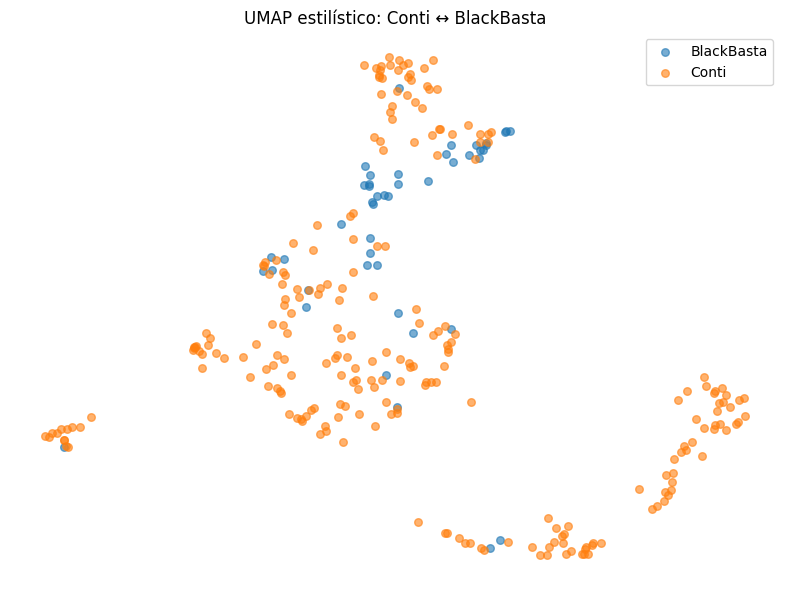

In [8]:
plt.figure(figsize=(8,6))

for fam, df in meta.groupby("family"):
    plt.scatter(df["x"], df["y"], label=fam, alpha=0.6, s=30)

plt.title("UMAP estilístico: Conti ↔ BlackBasta")
plt.legend()
plt.axis("off")
plt.tight_layout()
plt.show()


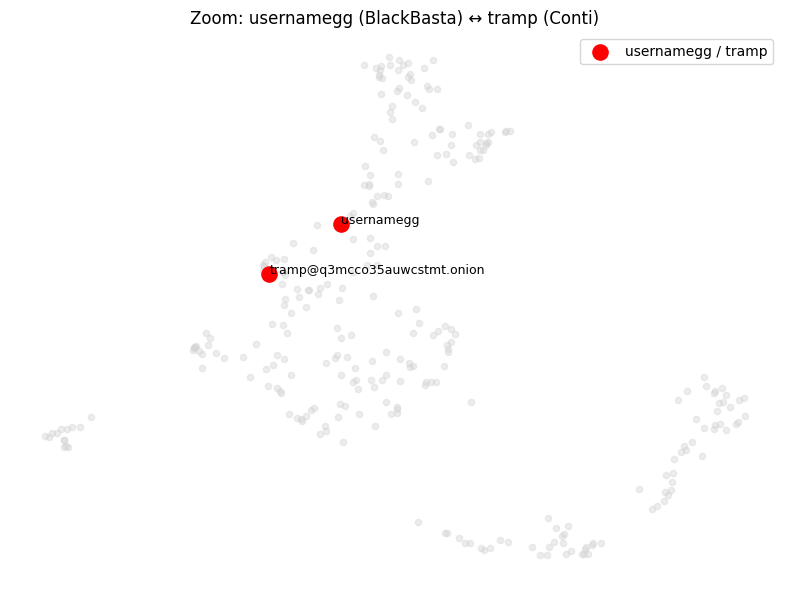

In [9]:
highlight = meta["actor"].str.contains("usernamegg|tramp", case=False, regex=True)

plt.figure(figsize=(8,6))

# fondo
plt.scatter(meta["x"], meta["y"], color="lightgrey", alpha=0.4, s=20)

# destacados
plt.scatter(
    meta.loc[highlight, "x"],
    meta.loc[highlight, "y"],
    color="red",
    s=120,
    label="usernamegg / tramp"
)

for _, r in meta[highlight].iterrows():
    plt.text(r["x"], r["y"], r["actor"], fontsize=9, ha="left")

plt.title("Zoom: usernamegg (BlackBasta) ↔ tramp (Conti)")
plt.legend()
plt.axis("off")
plt.tight_layout()
plt.show()


In [18]:
#Vecinos más cercanos de usernamegg
sim = pd.read_csv(sim_path)

neighbors = (
    sim[sim["bb_actor"].str.lower() == "usernamegg"]
    .sort_values("rank")
    .head(15)
)

neighbors


,bb_actor,conti_actor,rank,cosine_sim
2900,usernamegg,electronic@q3mcco35auwcstmt.onion,1,0.931335
2901,usernamegg,tl1,2,0.927959
2902,usernamegg,professor@q3mcco35auwcstmt.onion,3,0.927249
2903,usernamegg,stern@q3mcco35auwcstmt.onion,4,0.924789
2904,usernamegg,rozetka@q3mcco35auwcstmt.onion,5,0.923391
2905,usernamegg,target@q3mcco35auwcstmt.onion,6,0.917252
2906,usernamegg,revers@q3mcco35auwcstmt.onion,7,0.900256
2907,usernamegg,alex,8,0.898018
2908,usernamegg,tl2,9,0.896486
2909,usernamegg,logan@q3mcco35auwcstmt.onion,10,0.888391


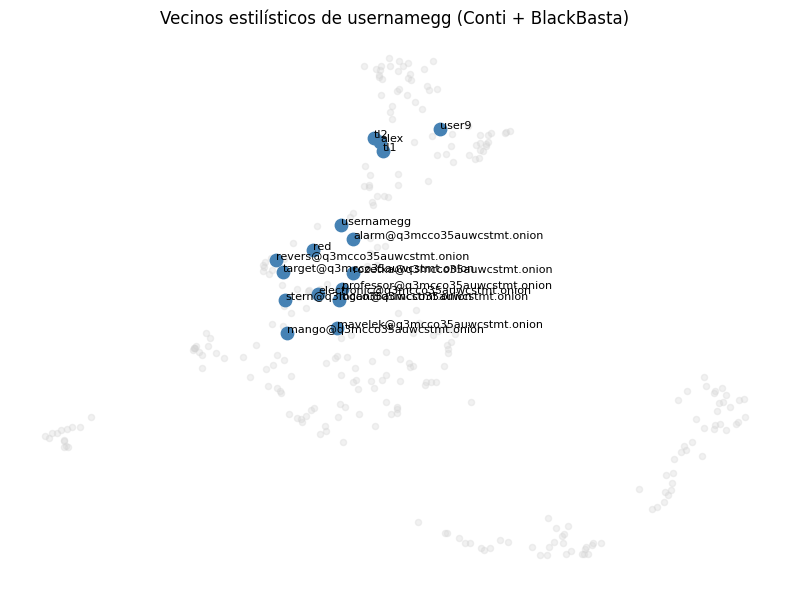

In [19]:
actors_of_interest = set(neighbors["conti_actor"].tolist() + ["usernamegg"])

mask = meta["actor"].isin(actors_of_interest)

plt.figure(figsize=(8,6))

# fondo
plt.scatter(meta["x"], meta["y"], color="lightgrey", alpha=0.3, s=20)

# vecinos
plt.scatter(
    meta.loc[mask, "x"],
    meta.loc[mask, "y"],
    color="steelblue",
    s=80,
)

for _, r in meta[mask].iterrows():
    plt.text(r["x"], r["y"], r["actor"], fontsize=8)

plt.title("Vecinos estilísticos de usernamegg (Conti + BlackBasta)")
plt.axis("off")
plt.tight_layout()
plt.show()


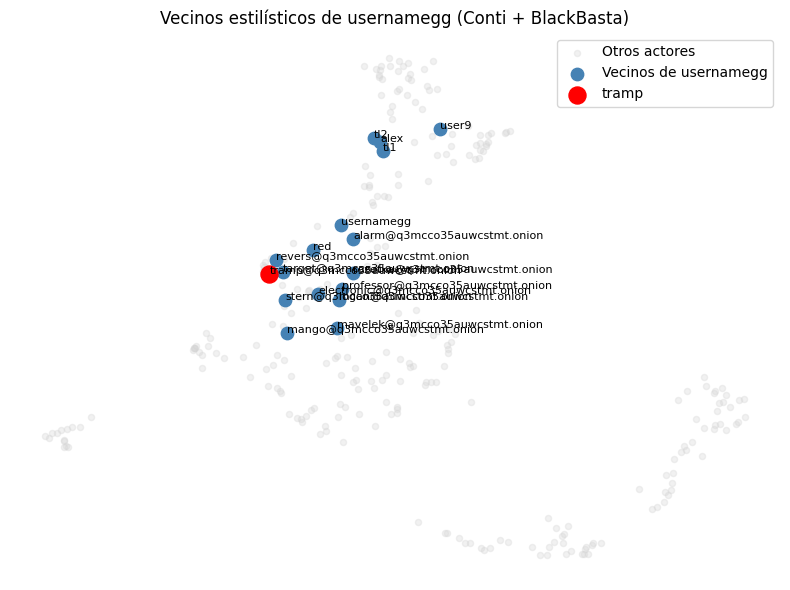

In [20]:
# actores de interés
actors_of_interest = set(neighbors["conti_actor"].tolist() + ["usernamegg"])

mask_neighbors = meta["actor"].isin(actors_of_interest)
mask_tramp = meta["actor"].str.contains("tramp", case=False, regex=True)

plt.figure(figsize=(8,6))

# fondo
plt.scatter(
    meta["x"],
    meta["y"],
    color="lightgrey",
    alpha=0.3,
    s=20,
    label="Otros actores"
)

# vecinos de usernamegg
plt.scatter(
    meta.loc[mask_neighbors, "x"],
    meta.loc[mask_neighbors, "y"],
    color="steelblue",
    s=80,
    label="Vecinos de usernamegg"
)

# tramp destacado
plt.scatter(
    meta.loc[mask_tramp, "x"],
    meta.loc[mask_tramp, "y"],
    color="red",
    s=150,
    label="tramp"
)

# etiquetas
for _, r in meta[mask_neighbors | mask_tramp].iterrows():
    plt.text(r["x"], r["y"], r["actor"], fontsize=8)

plt.title("Vecinos estilísticos de usernamegg (Conti + BlackBasta)")
plt.legend()
plt.axis("off")
plt.tight_layout()
plt.show()


## Conclusiones

- Los actores de BlackBasta se proyectan dentro del espacio estilístico aprendido a partir de Conti, sin separación clara por familia.
- El actor `usernamegg` cae en el mismo subespacio que el núcleo operativo de Conti.
- `tramp` aparece como vecino cercano (top 10 %), con similitud coseno elevada.
- El modelo no fuerza identidades, pero detecta continuidad discursiva consistente.

Este enfoque permite estudiar atribución estilística *cross-familia* de forma reproducible y cuantificable.

